# DAEN 429 Project
#### Gabriel Gonzalez and Leisha Khapre







## Code Pipeline

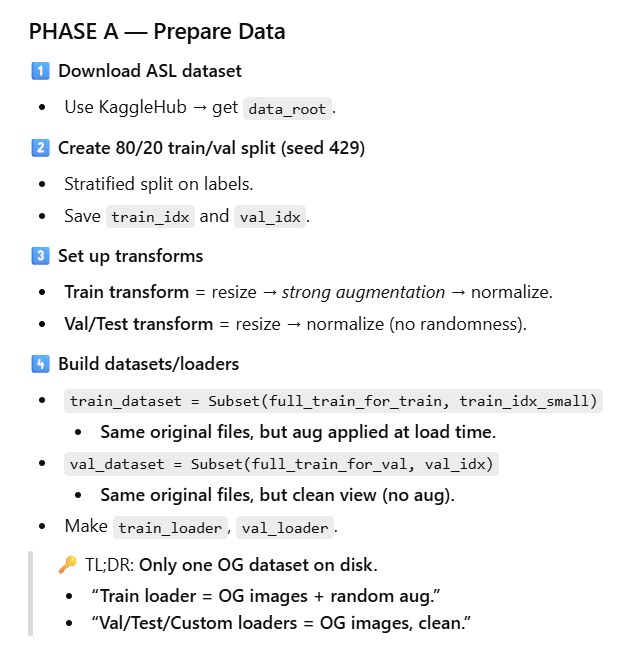

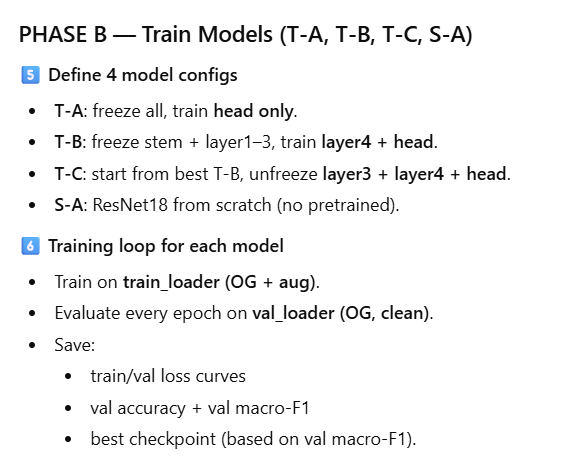

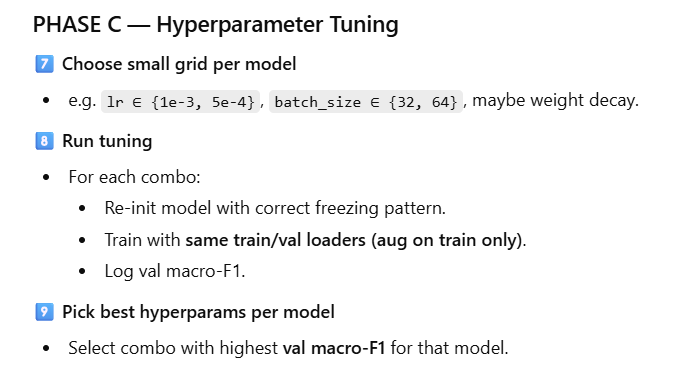

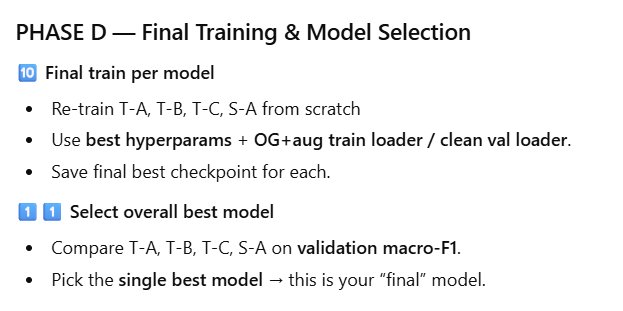

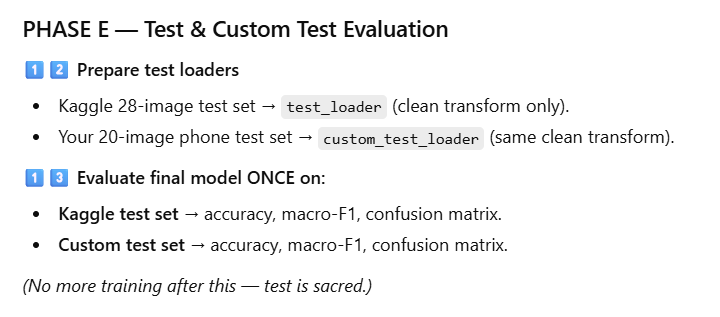



## Data Augmentation/ Phase A

In [1]:
# ==== 1. Imports ====
import os
import kagglehub
import numpy as np

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# ==== 2. Download ASL dataset & set root ====
path = kagglehub.dataset_download("grassknoted/asl-alphabet")
print("Path to dataset files:", path)

data_root = os.path.join(path, "asl_alphabet_train", "asl_alphabet_train")

# ==== 3. Transforms (augment only train) ====
train_transform = transforms.Compose([
    # Random crop & scale to force different zoom/position
    transforms.RandomResizedCrop(
        size=(224, 224),
        scale=(0.7, 1.0),       # was full image; now can zoom in up to 30%
        ratio=(0.9, 1.1),
    ),
    # Stronger rotations (but still not crazy)
    transforms.RandomRotation(degrees=25),
    # Stronger color / brightness changes
    transforms.ColorJitter(
        brightness=0.4,         # was 0.2
        contrast=0.4,           # was 0.2
        saturation=0.3,         # was 0.2
        hue=0.05,               # small hue shift
    ),
    # Slight geometric distortion
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    # A bit more blur, but not too much
    transforms.GaussianBlur(kernel_size=5),

    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
])

Using Colab cache for faster access to the 'asl-alphabet' dataset.
Path to dataset files: /kaggle/input/asl-alphabet


In [2]:
# Two ImageFolders sharing the same files but different transforms
full_train_for_train = datasets.ImageFolder(root=data_root, transform=train_transform)
full_train_for_val   = datasets.ImageFolder(root=data_root, transform=val_transform)

In [3]:
# ==== 4. Stratified 80/20 split with seed 429 (spec requirement) ====
labels = np.array(full_train_for_train.targets)
indices = np.arange(len(full_train_for_train))

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=labels,
    random_state=429,
)

# ==== 5. (Optional) shrink training set to speed things up ====
rng = np.random.default_rng(429)
subset_frac = 0.25              # use 25% of train; tweak if needed
subset_size = int(len(train_idx) * subset_frac)

train_idx_small = rng.choice(train_idx, size=subset_size, replace=False)

print("Original train size:", len(train_idx))
print("Subset train size:", len(train_idx_small))
print("Val size:", len(val_idx))

# ==== 6. Final Datasets & Dataloaders ====
train_dataset = Subset(full_train_for_train, train_idx_small)  # augmented
val_dataset   = Subset(full_train_for_val,   val_idx)          # clean

batch_size = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
)

print("Done: train_loader & val_loader ready.")

Original train size: 69600
Subset train size: 17400
Val size: 17400
Done: train_loader & val_loader ready.


### Validation to see if the images have been manipulated:

Class: A


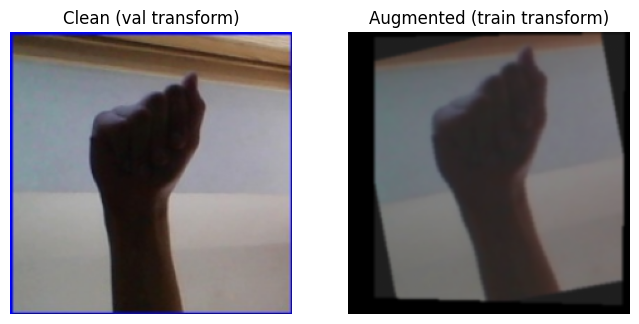

In [ ]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import numpy as np

# --- helper to "unnormalize" for plotting ---
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def show_tensor_img(img_tensor, title=""):
    """
    img_tensor: C x H x W tensor in [-?, ?] with ImageNet normalization.
    """
    img = img_tensor.clone().cpu()
    img = img * std + mean          # unnormalize
    img = img.clamp(0, 1)           # keep in valid range
    img = img.permute(1, 2, 0).numpy()  # C,H,W -> H,W,C
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title)

# --- pick an index to compare ---
idx = 0   # you can change this

aug_img, aug_label   = full_train_for_train[idx]  # with augmentation
clean_img, clean_label = full_train_for_val[idx]  # no augmentation

print("Class:", full_train_for_train.classes[aug_label])

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
show_tensor_img(clean_img, title="Clean (val transform)")

plt.subplot(1,2,2)
show_tensor_img(aug_img, title="Augmented (train transform)")
plt.show()


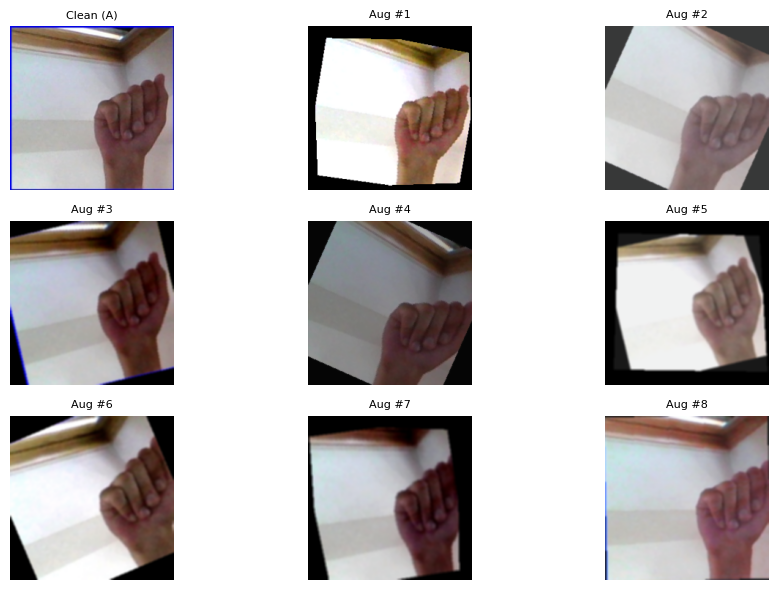

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# same unnormalize helper
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

def show_tensor_img(img_tensor, title=""):
    img = img_tensor.clone().cpu()
    img = img * std + mean
    img = img.clamp(0, 1)
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title, fontsize=8)

# choose a base index
idx = 10   # change this to try another image

clean_img, label = full_train_for_val[idx]
class_name = full_train_for_val.classes[label]

# build a small figure: 1 clean + 8 augmented
plt.figure(figsize=(10, 6))

# (0) clean
plt.subplot(3, 3, 1)
show_tensor_img(clean_img, title=f"Clean ({class_name})")

# (1–8) different augmented versions (calling the train dataset repeatedly)
for i in range(8):
    aug_img, _ = full_train_for_train[idx]   # same index, new random aug each time
    plt.subplot(3, 3, i+2)
    show_tensor_img(aug_img, title=f"Aug #{i+1}")

plt.tight_layout()
plt.show()


## Phase B- Training the Models

In [2]:
# =========================
# PHASE B + C: MODELS & TRAINING
# =========================
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
from torchvision.models import resnet18, ResNet18_Weights
import itertools
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type != "cuda":
    print("⚠️ WARNING: You are NOT on GPU. Go to Runtime → Change runtime type → GPU.")

criterion = nn.CrossEntropyLoss()
NUM_CLASSES = 29  # ASL Alphabet has 29 classes [1]

# ---------- Generic training loop (Phase B/C) ----------
def train_one_model(
    model,
    train_loader,
    val_loader,
    lr=1e-3,
    num_epochs=5,
    name="model",
    save_path=None,
):
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr,
    )

    best_f1 = 0.0
    best_state = None

    history = {
        "epoch": [],
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_macroF1": [],
    }

    for epoch in range(num_epochs):
        # ----- TRAIN -----
        model.train()
        train_loss = 0.0
        total_train = 0

        train_bar = tqdm(train_loader, desc=f"[{name}] Epoch {epoch+1}/{num_epochs}")

        for batch_idx, (x, y) in enumerate(train_bar):
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)
            total_train += x.size(0)

            running_loss = train_loss / total_train
            train_bar.set_postfix(running_loss=f"{running_loss:.4f}")

        train_loss /= total_train

        # ----- VALIDATE -----
        model.eval()
        val_loss = 0.0
        all_y, all_pred = [], []

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)
                val_loss += loss.item() * x.size(0)

                preds = logits.argmax(dim=1)
                all_y.append(y.cpu())
                all_pred.append(preds.cpu())

        val_loss /= len(val_loader.dataset)
        all_y = torch.cat(all_y).numpy()
        all_pred = torch.cat(all_pred).numpy()
        val_acc = accuracy_score(all_y, all_pred)
        val_f1 = f1_score(all_y, all_pred, average="macro")

        print(
            f"[{name}] Epoch {epoch+1}/{num_epochs} "
            f"train_loss={train_loss:.4f} "
            f"val_loss={val_loss:.4f} "
            f"val_acc={val_acc:.4f} "
            f"val_macroF1={val_f1:.4f}"
        )

        history["epoch"].append(epoch + 1)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_macroF1"].append(val_f1)

        # track best checkpoint by val macro‑F1 (Phase B requirement) [1]
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_state = model.state_dict().copy()

    if best_state is None:
        best_state = model.state_dict()

    if save_path is not None:
        torch.save(best_state, save_path)
        print(f"✅ Best {name} val_macroF1 = {best_f1:.4f} (saved to {save_path})")
    else:
        print(f"✅ Best {name} val_macroF1 = {best_f1:.4f}")

    return history, best_f1




Using device: cuda


In [3]:
# ---------- Base ResNet and freezing policies (Phase B) ----------
def get_base_resnet_pretrained():
    """ResNet18 with ImageNet weights and ASL head (used for T‑A/B/C)."""
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, NUM_CLASSES)
    return model

def get_base_resnet_scratch():
    """ResNet18 from scratch (used if you want S‑A as ResNet instead of custom CNN)."""
    model = resnet18(weights=None)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, NUM_CLASSES)
    return model

# T‑A: freeze all layers, train head only [1]
def apply_TA_freeze(model):
    for p in model.parameters():
        p.requires_grad = False
    for p in model.fc.parameters():
        p.requires_grad = True
    return model

# T‑B: freeze stem + layer1–3, train layer4 + head [1]
def apply_TB_freeze(model):
    for p in model.parameters():
        p.requires_grad = False
    for name, module in model.named_children():
        if name in ["layer4", "fc"]:
            for p in module.parameters():
                p.requires_grad = True
    return model

# T‑C: start from best T‑B, unfreeze layer3 + layer4 + head [1]
def apply_TC_freeze(model):
    for p in model.parameters():
        p.requires_grad = False
    for name, module in model.named_children():
        if name in ["layer3", "layer4", "fc"]:
            for p in module.parameters():
                p.requires_grad = True
    return model

# Keep frozen BatchNorm layers in eval mode to avoid running‑stat drift [1]
def update_bn_freeze(model):
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d) and (module.weight is not None) and (not module.weight.requires_grad):
            module.eval()


# ---------- Custom CNN for S‑A (from scratch) ----------
class ASL_CNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = self.pool4(torch.relu(self.bn4(self.conv4(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


# ---------- Helper to build each model type ----------
def build_model(model_type, tb_checkpoint_path=None):
    """
    model_type in {"TA", "TB", "TC", "SA"}.
    For T‑C, if tb_checkpoint_path is provided, we load T‑B weights first
    (as required: 'start from best T‑B checkpoint') [1].
    """
    if model_type == "TA":
        m = apply_TA_freeze(get_base_resnet_pretrained())
        update_bn_freeze(m)
        return m

    elif model_type == "TB":
        m = apply_TB_freeze(get_base_resnet_pretrained())
        update_bn_freeze(m)
        return m

    elif model_type == "TC":
        # Start from best T‑B checkpoint if provided
        m = get_base_resnet_pretrained()
        if tb_checkpoint_path is not None:
            state = torch.load(tb_checkpoint_path, map_location="cpu")
            m.load_state_dict(state)
        m = apply_TC_freeze(m)
        update_bn_freeze(m)
        return m

    elif model_type == "SA":
        # From scratch, custom CNN
        return ASL_CNN(num_classes=NUM_CLASSES)

    else:
        raise ValueError(f"Unknown model_type: {model_type}")



## PHASE C: Hyperparameter Tuning

In [4]:
# For plotting curves

import matplotlib.pyplot as plt

def plot_history(history, title="Model"):
    epochs = history["epoch"]

    plt.figure(figsize=(10,4))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train loss")
    plt.plot(epochs, history["val_loss"],   label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} – Loss")
    plt.legend()

    # Accuracy or macro‑F1 (choose what you want to show)
    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_acc"],      label="Val accuracy")
    plt.plot(epochs, history["val_macroF1"],  label="Val macro‑F1")
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title(f"{title} – Validation Metrics")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [7]:
os.makedirs("checkpoints", exist_ok=True)

def tune_model_type(
    model_type,
    train_loader,
    val_loader,
    lrs,
    epoch_options,
    base_name=None,
    tb_best_path=None,   # only used for T‑C
):
    if base_name is None:
        base_name = model_type

    best_overall_f1 = 0.0
    best_overall_cfg = None
    best_overall_path = None
    best_overall_history = None   # <‑‑ add this

    results = []

    for lr, num_epochs in itertools.product(lrs, epoch_options):
        cfg_name = f"{base_name}_lr{lr}_ep{num_epochs}"
        print(f"\n===== Tuning {model_type}: lr={lr}, epochs={num_epochs} =====")

        model = build_model(model_type, tb_checkpoint_path=tb_best_path).to(device)

        save_path = f"checkpoints/best_{cfg_name}.pth"
        history, val_f1 = train_one_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            lr=lr,
            num_epochs=num_epochs,
            name=cfg_name,
            save_path=save_path,
        )

        results.append(
            {
                "model_type": model_type,
                "lr": lr,
                "epochs": num_epochs,
                "val_macroF1": val_f1,
                "save_path": save_path,
            }
        )

        if val_f1 > best_overall_f1:
            best_overall_f1 = val_f1
            best_overall_cfg = (lr, num_epochs)
            best_overall_path = save_path
            best_overall_history = history      # <‑‑ store best history

    print(
        f"\n=== Best {model_type} === "
        f"F1={best_overall_f1:.4f} "
        f"@ lr={best_overall_cfg[0]}, epochs={best_overall_cfg[1]}"
    )
    print(f"Checkpoint: {best_overall_path}")

    # return best history too
    return (
        results,
        best_overall_f1,
        best_overall_cfg,
        best_overall_path,
        best_overall_history,
    )




===== Tuning TA: lr=0.001, epochs=3 =====
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


[TA_lr0.001_ep3] Epoch 1/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TA_lr0.001_ep3] Epoch 1/3 train_loss=2.4803 val_loss=1.6590 val_acc=0.6098 val_macroF1=0.6060


[TA_lr0.001_ep3] Epoch 2/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TA_lr0.001_ep3] Epoch 2/3 train_loss=1.6680 val_loss=1.3027 val_acc=0.6398 val_macroF1=0.6363


[TA_lr0.001_ep3] Epoch 3/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TA_lr0.001_ep3] Epoch 3/3 train_loss=1.4091 val_loss=1.0785 val_acc=0.7076 val_macroF1=0.7066
✅ Best TA_lr0.001_ep3 val_macroF1 = 0.7066 (saved to checkpoints/best_TA_lr0.001_ep3.pth)

===== Tuning TA: lr=0.0003, epochs=3 =====


[TA_lr0.0003_ep3] Epoch 1/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TA_lr0.0003_ep3] Epoch 1/3 train_loss=2.9919 val_loss=2.4939 val_acc=0.4314 val_macroF1=0.3944


[TA_lr0.0003_ep3] Epoch 2/3:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[TA_lr0.0003_ep3] Epoch 2/3 train_loss=2.3711 val_loss=1.9567 val_acc=0.5598 val_macroF1=0.5515


[TA_lr0.0003_ep3] Epoch 3/3:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
  Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
 ^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ 
   File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ ^ ^ ^ ^ ^ ^ ^ ^ ^ 
^  File "/us

[TA_lr0.0003_ep3] Epoch 3/3 train_loss=2.0136 val_loss=1.6825 val_acc=0.6090 val_macroF1=0.6063
✅ Best TA_lr0.0003_ep3 val_macroF1 = 0.6063 (saved to checkpoints/best_TA_lr0.0003_ep3.pth)

=== Best TA === F1=0.7066 @ lr=0.001, epochs=3
Checkpoint: checkpoints/best_TA_lr0.001_ep3.pth


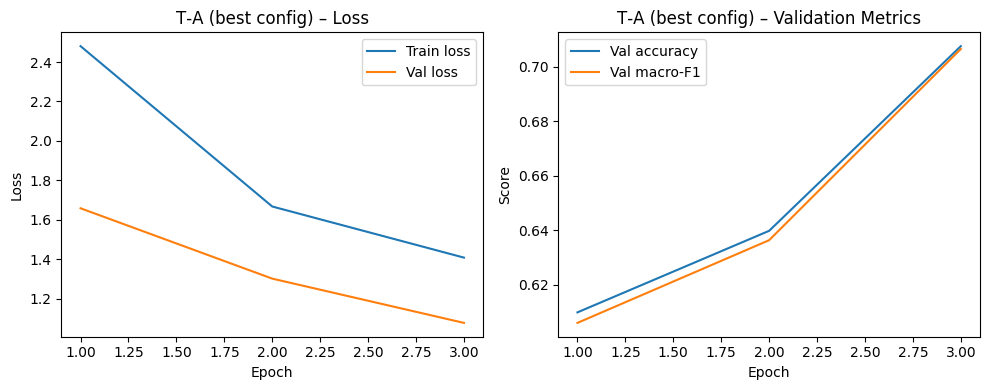

In [8]:
# ----- Run tuning in Phase C -----

# T-A
TA_lrs = [1e-3, 3e-4]  # head‑only; can be higher LR
TA_epochs = [3]

results_TA, best_f1_TA, best_cfg_TA, best_path_TA, best_hist_TA = tune_model_type(
    "TA", train_loader, val_loader, TA_lrs, TA_epochs
)
plot_history(best_hist_TA, title="T‑A (best config)")


===== Tuning TB: lr=0.0001, epochs=3 =====


[TB_lr0.0001_ep3] Epoch 1/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TB_lr0.0001_ep3] Epoch 1/3 train_loss=0.9515 val_loss=0.1232 val_acc=0.9844 val_macroF1=0.9845


[TB_lr0.0001_ep3] Epoch 2/3:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
     self._shutdown_workers()
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive():  
   ^ ^  ^^  ^^^^^^^^^^^^^^^^^^^^

  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
        assert self.

[TB_lr0.0001_ep3] Epoch 2/3 train_loss=0.1464 val_loss=0.0460 val_acc=0.9931 val_macroF1=0.9931


[TB_lr0.0001_ep3] Epoch 3/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TB_lr0.0001_ep3] Epoch 3/3 train_loss=0.0794 val_loss=0.0234 val_acc=0.9961 val_macroF1=0.9961
✅ Best TB_lr0.0001_ep3 val_macroF1 = 0.9961 (saved to checkpoints/best_TB_lr0.0001_ep3.pth)

===== Tuning TB: lr=0.0003, epochs=3 =====


[TB_lr0.0003_ep3] Epoch 1/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TB_lr0.0003_ep3] Epoch 1/3 train_loss=0.4922 val_loss=0.0465 val_acc=0.9892 val_macroF1=0.9892


[TB_lr0.0003_ep3] Epoch 2/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TB_lr0.0003_ep3] Epoch 2/3 train_loss=0.0869 val_loss=0.0230 val_acc=0.9938 val_macroF1=0.9938


[TB_lr0.0003_ep3] Epoch 3/3:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[TB_lr0.0003_ep3] Epoch 3/3 train_loss=0.0641 val_loss=0.0170 val_acc=0.9958 val_macroF1=0.9958
✅ Best TB_lr0.0003_ep3 val_macroF1 = 0.9958 (saved to checkpoints/best_TB_lr0.0003_ep3.pth)

=== Best TB === F1=0.9961 @ lr=0.0001, epochs=3
Checkpoint: checkpoints/best_TB_lr0.0001_ep3.pth


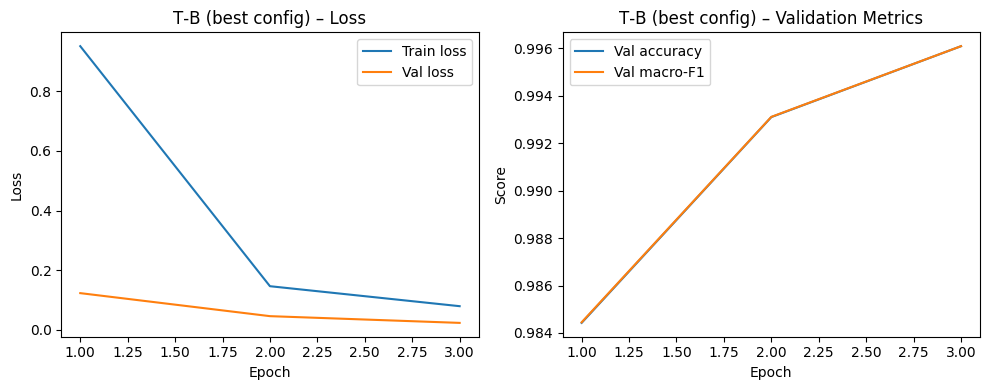

In [9]:
# T‑B
TB_lrs = [1e-4, 3e-4]
TB_epochs = [3]

results_TB, best_f1_TB, best_cfg_TB, best_path_TB, best_hist_TB = tune_model_type(
    "TB", train_loader, val_loader, TB_lrs, TB_epochs
)
plot_history(best_hist_TB, title="T‑B (best config)")


===== Tuning TC: lr=0.0001, epochs=3 =====


[TC_lr0.0001_ep3] Epoch 1/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TC_lr0.0001_ep3] Epoch 1/3 train_loss=0.0573 val_loss=0.0142 val_acc=0.9957 val_macroF1=0.9957


[TC_lr0.0001_ep3] Epoch 2/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TC_lr0.0001_ep3] Epoch 2/3 train_loss=0.0325 val_loss=0.0057 val_acc=0.9991 val_macroF1=0.9991


[TC_lr0.0001_ep3] Epoch 3/3:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
      Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
 Traceback (most recent call last):
   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
      ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^^  ^^ ^ ^^^^^^^^^^

[TC_lr0.0001_ep3] Epoch 3/3 train_loss=0.0212 val_loss=0.0077 val_acc=0.9980 val_macroF1=0.9980
✅ Best TC_lr0.0001_ep3 val_macroF1 = 0.9991 (saved to checkpoints/best_TC_lr0.0001_ep3.pth)

===== Tuning TC: lr=0.0003, epochs=3 =====


[TC_lr0.0003_ep3] Epoch 1/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TC_lr0.0003_ep3] Epoch 1/3 train_loss=0.1002 val_loss=0.0134 val_acc=0.9960 val_macroF1=0.9960


[TC_lr0.0003_ep3] Epoch 2/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TC_lr0.0003_ep3] Epoch 2/3 train_loss=0.0519 val_loss=0.0152 val_acc=0.9958 val_macroF1=0.9958


[TC_lr0.0003_ep3] Epoch 3/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TC_lr0.0003_ep3] Epoch 3/3 train_loss=0.0380 val_loss=0.0192 val_acc=0.9934 val_macroF1=0.9935
✅ Best TC_lr0.0003_ep3 val_macroF1 = 0.9960 (saved to checkpoints/best_TC_lr0.0003_ep3.pth)

=== Best TC === F1=0.9991 @ lr=0.0001, epochs=3
Checkpoint: checkpoints/best_TC_lr0.0001_ep3.pth


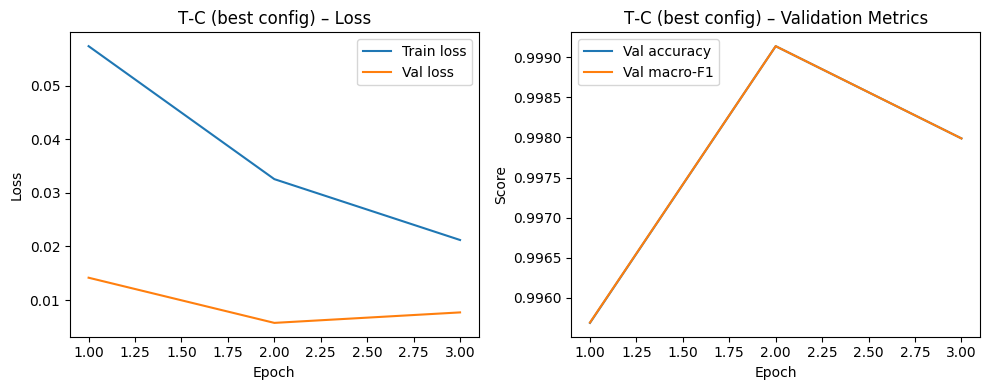

In [10]:
# T‑C (initialized from best T‑B)
TC_lrs = [1e-4, 3e-4]
TC_epochs = [3]

results_TC, best_f1_TC, best_cfg_TC, best_path_TC, best_hist_TC = tune_model_type(
    "TC", train_loader, val_loader, TC_lrs, TC_epochs, tb_best_path=best_path_TB
)
plot_history(best_hist_TC, title="T‑C (best config)")



===== Tuning SA: lr=0.001, epochs=5 =====


[SA_lr0.001_ep5] Epoch 1/5:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep5] Epoch 1/5 train_loss=3.2180 val_loss=3.0128 val_acc=0.0975 val_macroF1=0.0639


[SA_lr0.001_ep5] Epoch 2/5:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep5] Epoch 2/5 train_loss=2.9090 val_loss=2.9919 val_acc=0.1490 val_macroF1=0.1251


[SA_lr0.001_ep5] Epoch 3/5:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep5] Epoch 3/5 train_loss=2.5397 val_loss=2.3344 val_acc=0.2764 val_macroF1=0.2563


[SA_lr0.001_ep5] Epoch 4/5:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep5] Epoch 4/5 train_loss=2.2684 val_loss=1.9022 val_acc=0.3640 val_macroF1=0.3257


[SA_lr0.001_ep5] Epoch 5/5:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep5] Epoch 5/5 train_loss=2.0596 val_loss=1.6443 val_acc=0.4124 val_macroF1=0.3913
✅ Best SA_lr0.001_ep5 val_macroF1 = 0.3913 (saved to checkpoints/best_SA_lr0.001_ep5.pth)

===== Tuning SA: lr=0.001, epochs=10 =====


[SA_lr0.001_ep10] Epoch 1/10:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>^
^Traceback (most recent call last):
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ ^ ^^^

[SA_lr0.001_ep10] Epoch 1/10 train_loss=3.1848 val_loss=2.8294 val_acc=0.1443 val_macroF1=0.1063


[SA_lr0.001_ep10] Epoch 2/10:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[SA_lr0.001_ep10] Epoch 2/10 train_loss=2.7257 val_loss=2.1432 val_acc=0.3105 val_macroF1=0.2687


[SA_lr0.001_ep10] Epoch 3/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep10] Epoch 3/10 train_loss=2.3337 val_loss=1.8967 val_acc=0.3536 val_macroF1=0.3104


[SA_lr0.001_ep10] Epoch 4/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep10] Epoch 4/10 train_loss=2.1003 val_loss=1.5402 val_acc=0.5011 val_macroF1=0.4828


[SA_lr0.001_ep10] Epoch 5/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep10] Epoch 5/10 train_loss=1.9303 val_loss=1.5820 val_acc=0.4559 val_macroF1=0.4308


[SA_lr0.001_ep10] Epoch 6/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep10] Epoch 6/10 train_loss=1.7888 val_loss=1.3065 val_acc=0.5457 val_macroF1=0.5146


[SA_lr0.001_ep10] Epoch 7/10:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[SA_lr0.001_ep10] Epoch 7/10 train_loss=1.6606 val_loss=1.0706 val_acc=0.6523 val_macroF1=0.6255


[SA_lr0.001_ep10] Epoch 8/10:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[SA_lr0.001_ep10] Epoch 8/10 train_loss=1.5247 val_loss=1.2129 val_acc=0.5805 val_macroF1=0.5801


[SA_lr0.001_ep10] Epoch 9/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep10] Epoch 9/10 train_loss=1.4179 val_loss=1.1812 val_acc=0.5721 val_macroF1=0.5407


[SA_lr0.001_ep10] Epoch 10/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_lr0.001_ep10] Epoch 10/10 train_loss=1.3103 val_loss=0.8572 val_acc=0.7079 val_macroF1=0.7152
✅ Best SA_lr0.001_ep10 val_macroF1 = 0.7152 (saved to checkpoints/best_SA_lr0.001_ep10.pth)

=== Best SA === F1=0.7152 @ lr=0.001, epochs=10
Checkpoint: checkpoints/best_SA_lr0.001_ep10.pth


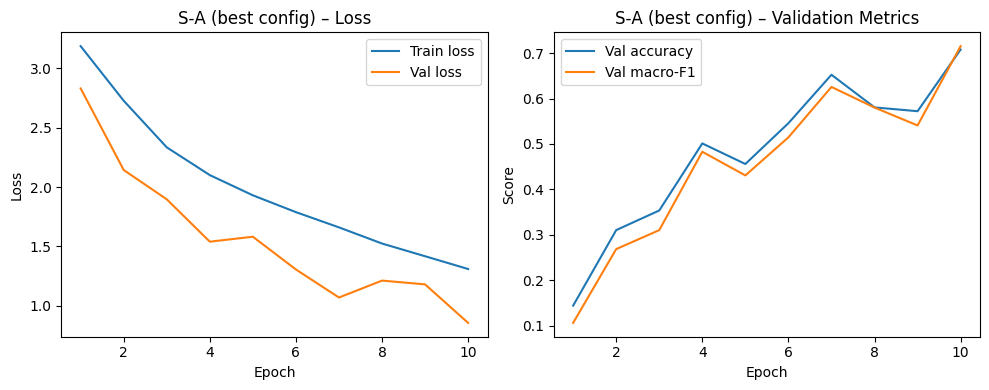

In [11]:
# S‑A (custom CNN)
SA_lrs = [1e-3]  # scratch; needs more epochs
SA_epochs = [5, 10]

results_SA, best_f1_SA, best_cfg_SA, best_path_SA, best_hist_SA = tune_model_type(
    "SA", train_loader, val_loader, SA_lrs, SA_epochs
)
plot_history(best_hist_SA, title="S‑A (best config)")

## Phase D


===== Final training TA with lr=0.001, epochs=3 =====


[TA_final_final] Epoch 1/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TA_final_final] Epoch 1/3 train_loss=2.4830 val_loss=1.7085 val_acc=0.5634 val_macroF1=0.5747


[TA_final_final] Epoch 2/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TA_final_final] Epoch 2/3 train_loss=1.6742 val_loss=1.3003 val_acc=0.6320 val_macroF1=0.6349


[TA_final_final] Epoch 3/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TA_final_final] Epoch 3/3 train_loss=1.4103 val_loss=1.0584 val_acc=0.7247 val_macroF1=0.7136
✅ Best TA_final_final val_macroF1 = 0.7136 (saved to checkpoints/final_TA_final.pth)


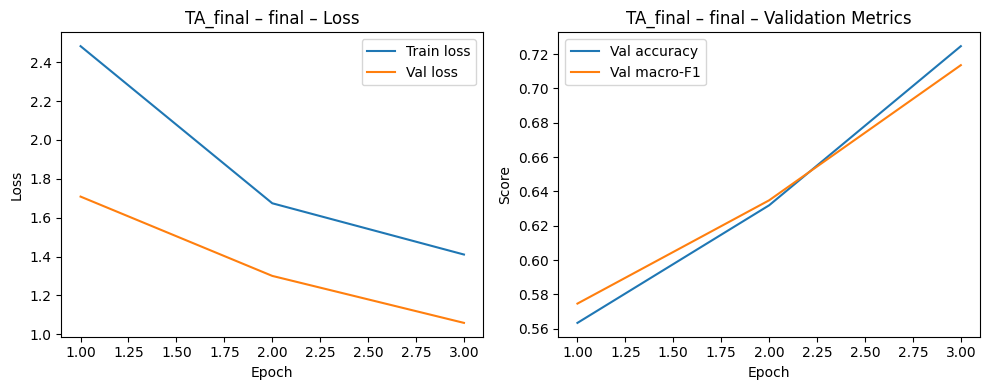

In [12]:
# =========================
# PHASE D: Final Training & Model Selection
# =========================

import torch

# 1) Final training per model with best hyperparameters from tuning

def final_train_model(model_type, best_cfg, base_name, tb_best_path=None):
    """
    model_type: "TA", "TB", "TC", "SA"
    best_cfg: (lr, epochs) from Phase C
    base_name: name prefix for logging / checkpoint
    tb_best_path: best T-B checkpoint, only needed for T-C start-from-TB behavior
    """
    best_lr, best_epochs = best_cfg
    print(f"\n===== Final training {model_type} with lr={best_lr}, epochs={best_epochs} =====")

    # For T-C we again start from best T-B checkpoint, then apply TC freeze
    model = build_model(model_type, tb_checkpoint_path=tb_best_path).to(device)

    save_path = f"checkpoints/final_{base_name}.pth"
    history, best_f1 = train_one_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        lr=best_lr,
        num_epochs=best_epochs,
        name=f"{base_name}_final",
        save_path=save_path,
    )

    # Plot curves for the final run (these are nice to show in the report)
    plot_history(history, title=f"{base_name} – final")

    return {
        "model_type": model_type,
        "best_lr": best_lr,
        "best_epochs": best_epochs,
        "val_macroF1": best_f1,
        "checkpoint": save_path,
        "history": history,
    }

# ---- Run final training for all four models ----

# T-A
final_TA = final_train_model(
    model_type="TA",
    best_cfg=best_cfg_TA,
    base_name="TA_final"
)




===== Final training TB with lr=0.0001, epochs=3 =====


[TB_final_final] Epoch 1/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TB_final_final] Epoch 1/3 train_loss=0.9409 val_loss=0.1205 val_acc=0.9852 val_macroF1=0.9852


[TB_final_final] Epoch 2/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TB_final_final] Epoch 2/3 train_loss=0.1431 val_loss=0.0420 val_acc=0.9922 val_macroF1=0.9922


[TB_final_final] Epoch 3/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TB_final_final] Epoch 3/3 train_loss=0.0755 val_loss=0.0259 val_acc=0.9959 val_macroF1=0.9959
✅ Best TB_final_final val_macroF1 = 0.9959 (saved to checkpoints/final_TB_final.pth)


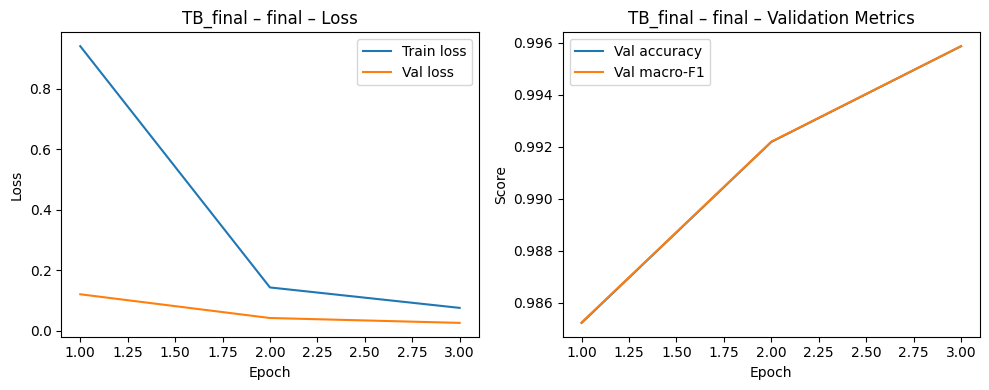

In [13]:
# T-B
final_TB = final_train_model(
    model_type="TB",
    best_cfg=best_cfg_TB,
    base_name="TB_final"
)




===== Final training TC with lr=0.0001, epochs=3 =====


[TC_final_final] Epoch 1/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TC_final_final] Epoch 1/3 train_loss=0.0579 val_loss=0.0174 val_acc=0.9963 val_macroF1=0.9963


[TC_final_final] Epoch 2/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TC_final_final] Epoch 2/3 train_loss=0.0332 val_loss=0.0100 val_acc=0.9978 val_macroF1=0.9978


[TC_final_final] Epoch 3/3:   0%|          | 0/272 [00:00<?, ?it/s]

[TC_final_final] Epoch 3/3 train_loss=0.0232 val_loss=0.0028 val_acc=0.9995 val_macroF1=0.9995
✅ Best TC_final_final val_macroF1 = 0.9995 (saved to checkpoints/final_TC_final.pth)


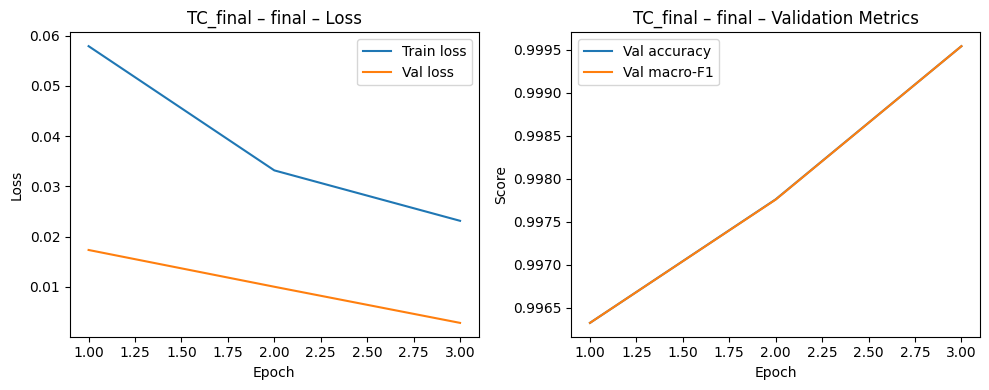

In [14]:
# T-C (must start from best T-B checkpoint again)
final_TC = final_train_model(
    model_type="TC",
    best_cfg=best_cfg_TC,
    base_name="TC_final",
    tb_best_path=best_path_TB,   # from Phase C tuning of T-B
)




===== Final training SA with lr=0.001, epochs=10 =====


[SA_final_final] Epoch 1/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_final_final] Epoch 1/10 train_loss=3.2029 val_loss=2.8911 val_acc=0.1251 val_macroF1=0.0663


[SA_final_final] Epoch 2/10:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[SA_final_final] Epoch 2/10 train_loss=2.7917 val_loss=2.3006 val_acc=0.2898 val_macroF1=0.2542


[SA_final_final] Epoch 3/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_final_final] Epoch 3/10 train_loss=2.3856 val_loss=2.0550 val_acc=0.3052 val_macroF1=0.2684


[SA_final_final] Epoch 4/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_final_final] Epoch 4/10 train_loss=2.1428 val_loss=1.7386 val_acc=0.4457 val_macroF1=0.4315


[SA_final_final] Epoch 5/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_final_final] Epoch 5/10 train_loss=1.9692 val_loss=1.5758 val_acc=0.4640 val_macroF1=0.4452


[SA_final_final] Epoch 6/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_final_final] Epoch 6/10 train_loss=1.8335 val_loss=1.3828 val_acc=0.5329 val_macroF1=0.5227


[SA_final_final] Epoch 7/10:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[SA_final_final] Epoch 7/10 train_loss=1.6999 val_loss=1.2608 val_acc=0.5787 val_macroF1=0.5620


[SA_final_final] Epoch 8/10:   0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d824ffd6980>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

[SA_final_final] Epoch 8/10 train_loss=1.6144 val_loss=1.0971 val_acc=0.6044 val_macroF1=0.5908


[SA_final_final] Epoch 9/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_final_final] Epoch 9/10 train_loss=1.4986 val_loss=0.9614 val_acc=0.6461 val_macroF1=0.6331


[SA_final_final] Epoch 10/10:   0%|          | 0/272 [00:00<?, ?it/s]

[SA_final_final] Epoch 10/10 train_loss=1.3939 val_loss=0.9703 val_acc=0.6599 val_macroF1=0.6578
✅ Best SA_final_final val_macroF1 = 0.6578 (saved to checkpoints/final_SA_final.pth)


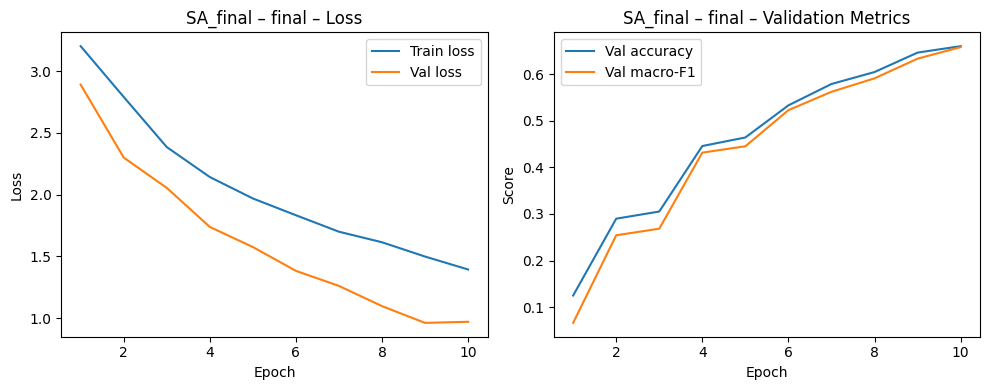

In [15]:
# S-A (custom CNN from scratch)
final_SA = final_train_model(
    model_type="SA",
    best_cfg=best_cfg_SA,
    base_name="SA_final"
)



In [16]:
# 2) Select overall best model based on validation macro-F1

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

all_final = [final_TA, final_TB, final_TC, final_SA]

best_model_info = max(all_final, key=lambda d: d["val_macroF1"])

import pickle

# existing code
all_final = [final_TA, final_TB, final_TC, final_SA]

best_model_info = max(all_final, key=lambda d: d["val_macroF1"])

print("\n===== PHASE D: Overall Best Model on Validation =====")
print(f"Model type: {best_model_info['model_type']}")
print(f"Val macro-F1: {best_model_info['val_macroF1']:.4f}")
print(f"Best lr: {best_model_info['best_lr']}")
print(f"Best epochs: {best_model_info['best_epochs']}")
print(f"Checkpoint path: {best_model_info['checkpoint']}")

best_model_type = best_model_info["model_type"]
best_model_ckpt = best_model_info["checkpoint"]

# ---- NEW: save best model meta‑info to .pkl ----
best_meta = {
    "model_type": best_model_type,
    "checkpoint": best_model_ckpt,
    "best_lr": best_model_info["best_lr"],
    "best_epochs": best_model_info["best_epochs"],
    "val_macroF1": best_model_info["val_macroF1"],
}


save_dir = "/content/drive/Shareddrives/429 Final Project"
os.makedirs(save_dir, exist_ok=True)

pkl_path  = os.path.join(save_dir, "best_model_info.pkl")
ckpt_path = os.path.join(save_dir, "final_TC_final.pth")  # or whatever you name it

with open(pkl_path, "wb") as f:
    pickle.dump(best_meta, f)

#torch.save(best_state, ckpt_path)

print("Saved best model info to best_model_info.pkl")

Mounted at /content/drive

===== PHASE D: Overall Best Model on Validation =====
Model type: TC
Val macro-F1: 0.9995
Best lr: 0.0001
Best epochs: 3
Checkpoint path: checkpoints/final_TC_final.pth
Saved best model info to best_model_info.pkl


In [20]:
import shutil, os, pickle

# 1) Paths
PROJECT_DIR = "/content/drive/Shareddrives/429 Final Project"
os.makedirs(PROJECT_DIR, exist_ok=True)

src_ckpt = "checkpoints/final_TC_final.pth"                   # local file
dst_ckpt = os.path.join(PROJECT_DIR, "final_TC_final.pth")    # in Drive

shutil.copy(src_ckpt, dst_ckpt)
print("Copied checkpoint to:", dst_ckpt)

Copied checkpoint to: /content/drive/Shareddrives/429 Final Project/final_TC_final.pth


In [21]:
# Load existing meta (if you want to reuse other fields)
PKL_PATH = os.path.join(PROJECT_DIR, "best_model_info.pkl")
with open(PKL_PATH, "rb") as f:
    best_info = pickle.load(f)

# Build new meta with Drive checkpoint path
best_meta = {
    "model_type": best_info["model_type"],          # e.g., "TC"
    "checkpoint": dst_ckpt,                         # << full Drive path
    "best_lr": best_info["best_lr"],
    "best_epochs": best_info["best_epochs"],
    "val_macroF1": best_info["val_macroF1"],
}

with open(PKL_PATH, "wb") as f:
    pickle.dump(best_meta, f)

print("Updated best_model_info.pkl with Drive checkpoint path.")

Updated best_model_info.pkl with Drive checkpoint path.


# Section 4.3/ Phase E

Using device: cuda
Mounted at /content/drive

=== BEST MODEL SELECTED ===
Model type: TC
Checkpoint: /content/drive/Shareddrives/429 Final Project/final_TC_final.pth
Val Macro-F1: 0.9995

=== OFFICIAL TEST RESULTS (28 images) ===
Accuracy : 0.9286
Macro-F1 : 0.8966


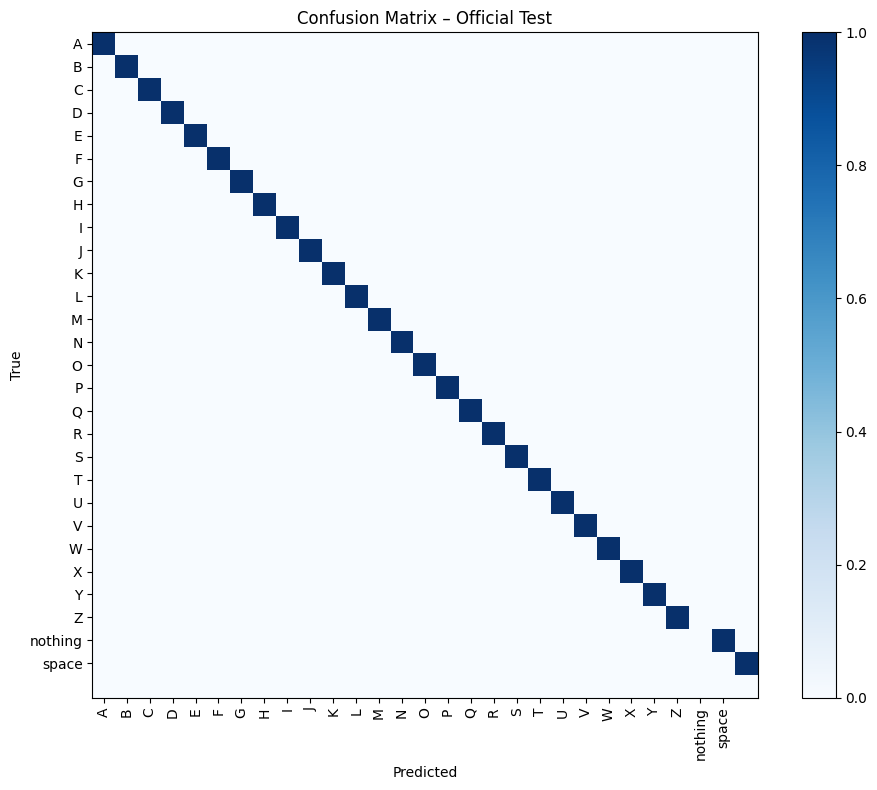


=== NEW 22-IMAGE TEST RESULTS ===
Accuracy : 0.2727
Macro-F1 : 0.1875


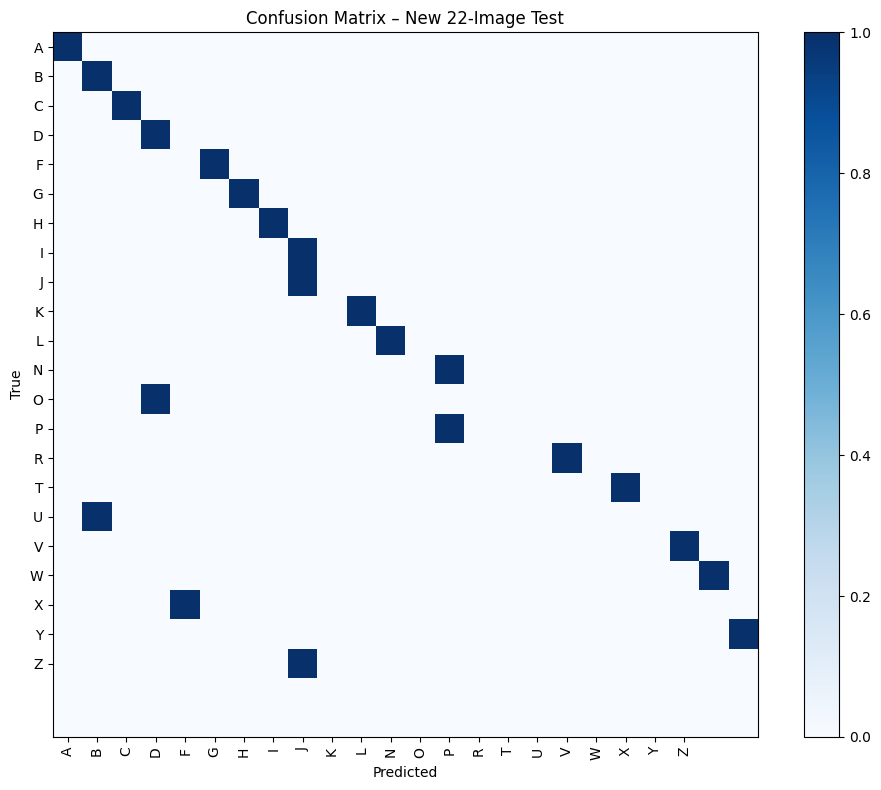

END


In [4]:
# =====================================
# PHASE 4.3 — TEST SET EVALUATION
# =====================================

import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pickle
import pandas as pd
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --------------------------------------------------
# Load Best Model Metadata
# --------------------------------------------------


from google.colab import drive
drive.mount("/content/drive", force_remount=True)

PROJECT_DIR = "/content/drive/Shareddrives/429 Final Project"
PKL_PATH    = os.path.join(PROJECT_DIR, "best_model_info.pkl")

with open(PKL_PATH, "rb") as f:
    best_info = pickle.load(f)

best_model_type = best_info["model_type"]
best_ckpt_rel   = best_info["checkpoint"]      # e.g. "checkpoints/final_TC_final.pth"
best_val_f1     = best_info["val_macroF1"]

# if checkpoint was copied into PROJECT_DIR, rebuild its full path:
best_ckpt_path = os.path.join(PROJECT_DIR, os.path.basename(best_ckpt_rel))

print("\n=== BEST MODEL SELECTED ===")
print("Model type:", best_model_type)
print("Checkpoint:", best_ckpt_path)
print("Val Macro-F1:", round(best_val_f1, 4))

# Rebuild & load weights
best_model = build_model(best_model_type).to(device)
best_model.load_state_dict(torch.load(best_ckpt_path, map_location=device))
best_model.eval()


# --------------------------------------------------
# Evaluation Helper
# --------------------------------------------------
def evaluate_loader(model, loader):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(y.numpy())

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="macro")
    return acc, f1, np.array(y_true), np.array(y_pred)


# --------------------------------------------------
# Confusion Matrix Plot Helper
# --------------------------------------------------
def plot_confusion_matrix(y_true, y_pred, labels, title, save_name):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(cm, cmap="Blues")

    plt.colorbar(im)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_yticklabels(labels)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.tight_layout()
    plt.savefig(save_name, dpi=200)
    plt.show()
    return cm


official_test_root = "/content/drive/Shareddrives/429 Final Project/asl_test_28"
new_test_root      = "/content/drive/Shareddrives/429 Final Project/asl_new_test_22"

# =====================================
# Load & Evaluate Official 28-Image Test
# =====================================
test28_ds = datasets.ImageFolder(root=official_test_root, transform=val_transform)
test28_ld = DataLoader(test28_ds, batch_size=16, shuffle=False)

#NEW
# Use test28_ds to get class names
class_names = test28_ds.classes


acc28, f128, y28, p28 = evaluate_loader(best_model, test28_ld)

print("\n=== OFFICIAL TEST RESULTS (28 images) ===")
print(f"Accuracy : {acc28:.4f}")
print(f"Macro-F1 : {f128:.4f}")

plot_confusion_matrix(
    y28, p28, class_names,
    "Confusion Matrix – Official Test",
    "cm_official_test.png"
)


# =====================================
# Load & Evaluate NEW 22-Image Real Test
# =====================================
test22_ds = datasets.ImageFolder(root=new_test_root, transform=val_transform)
test22_ld = DataLoader(test22_ds, batch_size=16, shuffle=False)

acc22, f122, y22, p22 = evaluate_loader(best_model, test22_ld)

print("\n=== NEW 22-IMAGE TEST RESULTS ===")
print(f"Accuracy : {acc22:.4f}")
print(f"Macro-F1 : {f122:.4f}")

plot_confusion_matrix(
    y22, p22, test22_ds.classes,
    "Confusion Matrix – New 22-Image Test",
    "cm_new_test.png"
)


print("END")
# display(ablation_df)


# THE END